In [105]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
tf.get_logger().setLevel('INFO')
from keras import backend as K

import os
from os import listdir
from PIL import Image


from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydot
from IPython.display import Image, display


from vit_keras import vit, utils, visualize

import time

In [110]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install imbalanced-learn
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install vit-keras
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install pydot

In [3]:
carrigan = False

### Load Data

In [4]:
if carrigan:
  df = pd.read_csv('/content/drive/MyDrive/Kidney Project Data/kidneyData.csv')
else:
  df = pd.read_csv('KidneyImages/kidneyData.csv')

In [5]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [6]:
newsize = (256, 256)

In [7]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary
        
        


In [8]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [10]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [11]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

## NEW PREPROCESSING FLOW STARTS HERE

In [12]:
## Preprocess the cyst images
# Sort them by image number
cysts = pd.DataFrame(cystImages)
cysts['number'] = cysts['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
cysts = cysts.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
cystsWithLabel = cysts.merge(df, how = 'inner', on = 'image_id')
cystsWithLabel = cystsWithLabel[['image', 'target']]
cystX = cystsWithLabel['image'].to_numpy()
cysty = cystsWithLabel['target'].to_numpy()
print(len(cystX))

# Reshape the array
cystX = np.array([x for x in cystX])
nsamples, nx, ny = cystX.shape
cystX = cystX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
cystX_and_y = np.column_stack((cystX, cysty))
cystX_and_y = pd.DataFrame(cystX_and_y)
cystX_and_y = cystX_and_y.drop_duplicates()
cystX = cystX_and_y.iloc[:,:-1].to_numpy()
cysty = cystX_and_y.iloc[:,-1:].to_numpy()
print(len(cystX))

3709
3284


In [13]:
## Preprocess the stone images
# Sort them by image number
stones = pd.DataFrame(stoneImages)
stones['number'] = stones['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
stones = stones.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
stonesWithLabel = stones.merge(df, how = 'inner', on = 'image_id')
stonesWithLabel = stonesWithLabel[['image', 'target']]
stoneX = stonesWithLabel['image'].to_numpy()
stoney = stonesWithLabel['target'].to_numpy()
print(len(stoneX))

# Reshape the array
stoneX = np.array([x for x in stoneX])
nsamples, nx, ny = stoneX.shape
stoneX = stoneX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
stoneX_and_y = np.column_stack((stoneX, stoney))
stoneX_and_y = pd.DataFrame(stoneX_and_y)
stoneX_and_y = stoneX_and_y.drop_duplicates()
stoneX = stoneX_and_y.iloc[:,:-1].to_numpy()
stoney = stoneX_and_y.iloc[:,-1:].to_numpy()
print(len(stoneX))

1377
1360


In [15]:
## Preprocess the normal images
# Sort them by image number
norms = pd.DataFrame(normalImages)
norms['number'] = norms['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
norms = norms.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
normsWithLabel = norms.merge(df, how = 'inner', on = 'image_id')
normsWithLabel = normsWithLabel[['image', 'target']]
normsX = normsWithLabel['image'].to_numpy()
normsy = normsWithLabel['target'].to_numpy()
print(len(normsX))

# Reshape the array
normsX = np.array([x for x in normsX])
nsamples, nx, ny = normsX.shape
normsX = normsX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
normsX_and_y = np.column_stack((normsX, normsy))
normsX_and_y = pd.DataFrame(normsX_and_y)
normsX_and_y = normsX_and_y.drop_duplicates()
normsX = normsX_and_y.iloc[:,:-1].to_numpy()
normsy = normsX_and_y.iloc[:,-1:].to_numpy()
print(len(normsX))

5077
5002


In [16]:
## Preprocess the tumor images
# Sort them by image number
tumor = pd.DataFrame(tumorImages)
tumor['number'] = tumor['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
tumor = tumor.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
tumorWithLabel = tumor.merge(df, how = 'inner', on = 'image_id')
tumorWithLabel = tumorWithLabel[['image', 'target']]
tumorX = tumorWithLabel['image'].to_numpy()
tumory = tumorWithLabel['target'].to_numpy()
print(len(tumorX))

# Reshape the array
tumorX = np.array([x for x in tumorX])
nsamples, nx, ny = tumorX.shape
tumorX = tumorX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
tumorX_and_y = np.column_stack((tumorX, tumory))
tumorX_and_y = pd.DataFrame(tumorX_and_y)
tumorX_and_y = tumorX_and_y.drop_duplicates()
tumorX = tumorX_and_y.iloc[:,:-1].to_numpy()
tumory = tumorX_and_y.iloc[:,-1:].to_numpy()
print(len(tumorX))

2283
2283


In [17]:
# Split into train, validation, and test sets
cyst60 = int(np.floor(cystX.shape[0]*0.6))
cyst20 = int(np.floor(cystX.shape[0]*0.2))
stone60 = int(np.floor(stoneX.shape[0]*0.6))
stone20 = int(np.floor(stoneX.shape[0]*0.2))
norm60 = int(np.floor(normsX.shape[0]*0.6))
norm20 = int(np.floor(normsX.shape[0]*0.2))
tumor60 = int(np.floor(tumorX.shape[0]*0.6))
tumor20 = int(np.floor(tumorX.shape[0]*0.2))

cystXtrain = cystX[:cyst60]
cystXval = cystX[cyst60:cyst60+cyst20]
cystXtest = cystX[cyst60+cyst20:]
cystytrain = cysty[:cyst60]
cystyval = cysty[cyst60:cyst60+cyst20]
cystytest = cysty[cyst60+cyst20:]

stoneXtrain = stoneX[:stone60]
stoneXval = stoneX[stone60:stone60+stone20]
stoneXtest = stoneX[stone60+stone20:]
stoneytrain = stoney[:stone60]
stoneyval = stoney[stone60:stone60+stone20]
stoneytest = stoney[stone60+stone20:]

normXtrain = normsX[:norm60]
normXval = normsX[norm60:norm60+norm20]
normXtest = normsX[norm60+norm20:]
normytrain = normsy[:norm60]
normyval = normsy[norm60:norm60+norm20]
normytest = normsy[norm60+norm20:]

tumorXtrain = tumorX[:tumor60]
tumorXval = tumorX[tumor60:tumor60+tumor20]
tumorXtest = tumorX[tumor60+tumor20:]
tumorytrain = tumory[:tumor60]
tumoryval = tumory[tumor60:tumor60+tumor20]
tumorytest = tumory[tumor60+tumor20:]


In [18]:
X_train_new = np.concatenate((cystXtrain, stoneXtrain, normXtrain, tumorXtrain))
X_val_new = np.concatenate((cystXval, stoneXval, normXval, tumorXval))
X_test_new = np.concatenate((cystXtest, stoneXtest, normXtest, tumorXtest))
y_train_new = np.concatenate((cystytrain, stoneytrain, normytrain, tumorytrain))
y_val_new = np.concatenate((cystyval, stoneyval, normyval, tumoryval))
y_test_new = np.concatenate((cystytest, stoneytest, normytest, tumorytest))
print(X_train_new.shape, X_val_new.shape, X_test_new.shape)
print(y_train_new.shape, y_val_new.shape, y_test_new.shape)

(7156, 65536) (2384, 65536) (2389, 65536)
(7156, 1) (2384, 1) (2389, 1)


Training Set


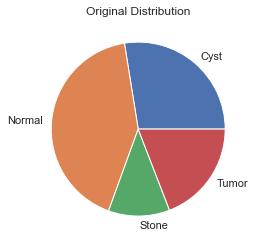

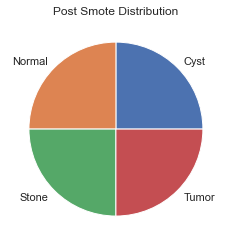

Validation Set


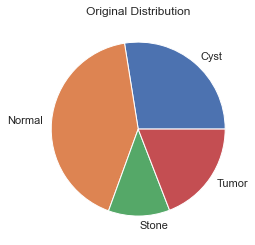

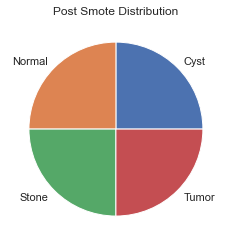

Test Set


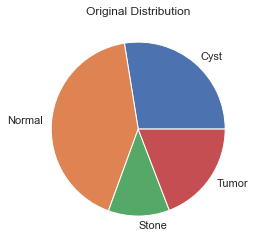

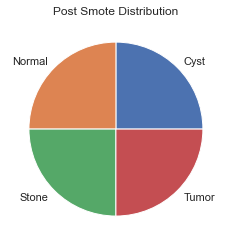

In [19]:
# SMOTE to balance classes

# Original class distribution
print('Training Set')
unique, counts = np.unique(y_train_new, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
XtrainsmoteNew, ytrainsmoteNew = oversample.fit_resample(X_train_new, y_train_new)


# Updated class distribution
uniquesmote, countssmote = np.unique(ytrainsmoteNew, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()


# Original class distribution
print('Validation Set')
unique, counts = np.unique(y_val_new, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
XvalsmoteNew, yvalsmoteNew = oversample.fit_resample(X_val_new, y_val_new)


# Updated class distribution
uniquesmote, countssmote = np.unique(yvalsmoteNew, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()


# Original class distribution
print('Test Set')
unique, counts = np.unique(y_test_new, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
XtestsmoteNew, ytestsmoteNew = oversample.fit_resample(X_test_new, y_test_new)


# Updated class distribution
uniquesmote, countssmote = np.unique(ytestsmoteNew, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [20]:
np.random.seed(42)
indices = np.arange(XtrainsmoteNew.shape[0])
shuffled_indices = np.random.permutation(indices)
X_trainshuf_new = XtrainsmoteNew[shuffled_indices]
y_trainshuf_new = ytrainsmoteNew[shuffled_indices]
print(X_train_new.shape)
print(X_trainshuf_new.shape)
print(y_trainshuf_new.shape)

indices = np.arange(XvalsmoteNew.shape[0])
shuffled_indices = np.random.permutation(indices)
X_valshuf_new = XvalsmoteNew[shuffled_indices]
y_valshuf_new = yvalsmoteNew[shuffled_indices]
print(X_val_new.shape)
print(X_valshuf_new.shape)
print(y_valshuf_new.shape)


indices = np.arange(XtestsmoteNew.shape[0])
shuffled_indices = np.random.permutation(indices)
X_testshuf_new = XtestsmoteNew[shuffled_indices]
y_testshuf_new = ytestsmoteNew[shuffled_indices]
print(X_test_new.shape)
print(X_testshuf_new.shape)
print(y_testshuf_new.shape)

(7156, 65536)
(12004, 65536)
(12004,)
(2384, 65536)
(4000, 65536)
(4000,)
(2389, 65536)
(4004, 65536)
(4004,)


## OLD PREPROCESSING FLOW BELOW

In [ ]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [ ]:
imgs

In [ ]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [ ]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [ ]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [ ]:
if carrigan:
  X = np.load('/content/drive/MyDrive/Kidney Project Data/X.npy', allow_pickle=True)
  y = np.load('/content/drive/MyDrive/Kidney Project Data/y.npy', allow_pickle=True)

### Drop Duplicates

In [ ]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

In [ ]:
X_and_y = np.column_stack((X, y))
print(X_and_y.shape)

In [ ]:
X_and_y = pd.DataFrame(X_and_y)
X_and_y = X_and_y.drop_duplicates()
print(X_and_y.shape)

In [ ]:
X = X_and_y.iloc[:,:-1].to_numpy()
y = X_and_y.iloc[:,-1:].to_numpy()
print(X.shape)
print(y.shape)

### Perform SMOTE

In [ ]:
# Divide by 255, keep as float32 data
# print(np.max(X))
# X = (X.astype(np.float32) / 255.0).astype(np.float32)
# print(np.max(X))

In [ ]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [ ]:
del X
del y
del X_and_y

### Shuffle & reshape the data

In [ ]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]
print(Xshuffled.shape)

In [ ]:
del Xsmote
del ysmote

### Train and test split

In [ ]:
X_train_flat, X_test_flat, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [ ]:
# Create an intermediary validation set
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=1)

In [ ]:
# Reshape the data to 4 dimensional data
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))

In [ ]:
del Xshuffled
del yshuffled

## HERE UPDATES OLD NAMES TO NEW NAMES
#### Start back here if skipping old processing flow

In [23]:
print(np.max(X_trainshuf_new))
X_trainrescale_new = (X_trainshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_valrescale_new = (X_valshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_testrescale_new = (X_testshuf_new.astype(np.float32) / 255.0).astype(np.float32)
print(np.max(X_testrescale_new))

255
1.0


In [36]:
X_train_flat = X_trainrescale_new
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
y_train = y_trainshuf_new

X_val_flat = X_valrescale_new
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))
y_val = y_valshuf_new
y_val = y_val.reshape((len(y_val), ))

X_test_flat = X_testrescale_new
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
y_test = y_testshuf_new
y_test = y_test.reshape((len(y_test), ))

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(12004, 256, 256, 1) (4000, 256, 256, 1) (4004, 256, 256, 1)
(12004, 65536) (4000, 65536) (4004, 65536)
(12004,) (4000,) (4004,)


### Image Augmentation

In [25]:
# Create augmentation layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])


(256, 256, 1)


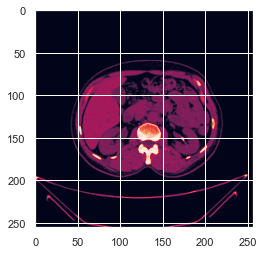

In [26]:
example_image = X_train[2]
print(example_image.shape)

plt.imshow(example_image)

In [30]:
plt.figure(figsize=(8, 7))
for i in range(6):
  aug_image = data_augmentation(example_image)
  ax = plt.subplot(2, 3, i + 1)
  plt.axis("off")

plt.show()

# Create Models

#### Create functions for class by class precision and recall

In [74]:
def recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())


def precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())


In [82]:
def recall_c1(y_true, y_pred):
    return recall(y_true, y_pred, 0)

def precision_c1(y_true, y_pred):
    return precision(y_true, y_pred, 0)

def recall_c2(y_true, y_pred):
    return recall(y_true, y_pred, 1)

def precision_c2(y_true, y_pred):
    return precision(y_true, y_pred, 1)

def recall_c3(y_true, y_pred):
    return recall(y_true, y_pred, 2)

def precision_c3(y_true, y_pred):
    return precision(y_true, y_pred, 2)

def recall_c4(y_true, y_pred):
    return recall(y_true, y_pred, 3)

def precision_c4(y_true, y_pred):
    return precision(y_true, y_pred, 3)

## Classical Machine Learning Models

### Model 1 - Multiclass Classifier

In [89]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        data_augmentation,
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    return model

In [92]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = build_multiclass_model(4, 0.001)
numEpochs = 20

startTime = time.time()
history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=numEpochs,
  batch_size=64,
  validation_data = (X_val, y_val),
  verbose=1)
endTime = time.time()

Epoch 1/20
188/188 [==============================] - 7s 31ms/step - loss: 1.4156 - accuracy: 0.2593 - recall_c1: 0.2702 - precision_c1: 0.2748 - recall_c2: 0.2758 - precision_c2: 0.2486 - recall_c3: 0.2493 - precision_c3: 0.2287 - recall_c4: 0.2485 - precision_c4: 0.2235 - val_loss: 1.3717 - val_accuracy: 0.3830 - val_recall_c1: 0.4867 - val_precision_c1: 0.3751 - val_recall_c2: 0.2696 - val_precision_c2: 0.4424 - val_recall_c3: 0.0992 - val_precision_c3: 0.2641 - val_recall_c4: 0.6742 - val_precision_c4: 0.3908
Epoch 2/20
188/188 [==============================] - 5s 29ms/step - loss: 1.3989 - accuracy: 0.2741 - recall_c1: 0.3274 - precision_c1: 0.3009 - recall_c2: 0.2900 - precision_c2: 0.2648 - recall_c3: 0.2198 - precision_c3: 0.2209 - recall_c4: 0.2581 - precision_c4: 0.2275 - val_loss: 1.3500 - val_accuracy: 0.3295 - val_recall_c1: 0.4498 - val_precision_c1: 0.3994 - val_recall_c2: 0.7244 - val_precision_c2: 0.2894 - val_recall_c3: 0.1302 - val_precision_c3: 0.5420 - val_recall_

Epoch 17/20
188/188 [==============================] - 5s 29ms/step - loss: 1.3672 - accuracy: 0.3171 - recall_c1: 0.3743 - precision_c1: 0.3207 - recall_c2: 0.3530 - precision_c2: 0.3223 - recall_c3: 0.2424 - precision_c3: 0.2740 - recall_c4: 0.2673 - precision_c4: 0.2750 - val_loss: 1.3152 - val_accuracy: 0.3870 - val_recall_c1: 0.3670 - val_precision_c1: 0.4995 - val_recall_c2: 0.3083 - val_precision_c2: 0.3372 - val_recall_c3: 0.5103 - val_precision_c3: 0.3434 - val_recall_c4: 0.3635 - val_precision_c4: 0.4223
Epoch 18/20
188/188 [==============================] - 5s 28ms/step - loss: 1.3609 - accuracy: 0.3130 - recall_c1: 0.3699 - precision_c1: 0.3136 - recall_c2: 0.3391 - precision_c2: 0.3026 - recall_c3: 0.2506 - precision_c3: 0.2854 - recall_c4: 0.2824 - precision_c4: 0.2967 - val_loss: 1.2927 - val_accuracy: 0.3478 - val_recall_c1: 0.2812 - val_precision_c1: 0.5531 - val_recall_c2: 0.3700 - val_precision_c2: 0.3446 - val_recall_c3: 0.5042 - val_precision_c3: 0.3035 - val_recal

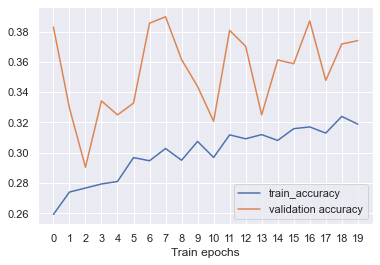

In [93]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [94]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.415626,0.259330,0.270191,0.274827,0.275807,0.248582,0.249330,0.228709,0.248481,0.223509,1.371735,0.38300,0.486743,0.375115,0.269612,0.442360,0.099193,0.264053,0.674165,0.390757
1,1.398873,0.274075,0.327377,0.300868,0.289990,0.264795,0.219844,0.220882,0.258119,0.227527,1.349986,0.32950,0.449814,0.399363,0.724442,0.289413,0.130216,0.541956,0.019698,0.137566
2,1.397263,0.276741,0.315304,0.289398,0.319975,0.287684,0.238972,0.231068,0.243917,0.271206,1.343887,0.29050,0.251241,0.427285,0.550724,0.336203,0.000000,0.000000,0.357198,0.201021
3,1.397682,0.279407,0.335089,0.272924,0.317240,0.286413,0.216819,0.251876,0.244705,0.240034,1.342753,0.33425,0.248631,0.607890,0.275388,0.280013,0.651002,0.307140,0.153996,0.352329
4,1.395581,0.281073,0.342895,0.310338,0.304768,0.270178,0.234076,0.220125,0.234848,0.252763,1.322992,0.32500,0.474585,0.422620,0.718490,0.300343,0.000000,0.000000,0.112289,0.226564
5,1.381122,0.296818,0.364624,0.303612,0.338981,0.292879,0.224754,0.240481,0.260864,0.286297,1.322844,0.33275,0.144476,0.735525,0.974408,0.285348,0.206980,0.603912,0.004822,0.035714
6,1.386317,0.294735,0.354380,0.298058,0.337848,0.302680,0.249618,0.257374,0.236266,0.251421,1.329073,0.38550,0.419405,0.493567,0.398978,0.395012,0.231498,0.607619,0.485266,0.276034
7,1.376022,0.302816,0.367049,0.300273,0.325117,0.297963,0.239570,0.261745,0.260613,0.262790,1.308071,0.38975,0.584519,0.462850,0.574200,0.310550,0.380647,0.532142,0.022717,0.134392
8,1.380993,0.295068,0.365984,0.316099,0.330450,0.303882,0.250158,0.259184,0.236712,0.223879,1.307325,0.36150,0.492587,0.462564,0.564339,0.373124,0.101637,0.523262,0.286044,0.232711
9,1.370682,0.307481,0.375984,0.311212,0.346084,0.321584,0.247208,0.291565,0.260590,0.267929,1.298974,0.34375,0.413553,0.450674,0.652754,0.307609,0.282597,0.575748,0.034685,0.080455


In [95]:
test_predictions = np.argmax(model1.predict(X_val), axis=-1)
print(test_predictions)

125/125 [==============================] - 0s 2ms/step
[2 2 2 ... 1 3 2]


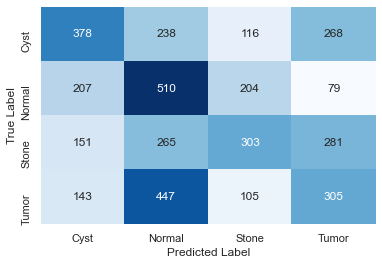

In [96]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [98]:
test_predictions = np.argmax(model1.predict(X_test), axis=-1)
print(test_predictions)

126/126 [==============================] - 2s 12ms/step
[0 0 1 ... 1 2 1]


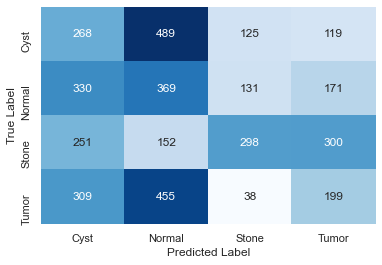

In [100]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [97]:
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 1.8564824302991232 minutes


### Model 2 - KNN

In [101]:
model2 = KNeighborsClassifier(n_neighbors=70, p=2, metric='minkowski')
startTime = time.time()
model2.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 0.013250199953715007 minutes


error: 0.6595
Val prediction accuracy: 0.341


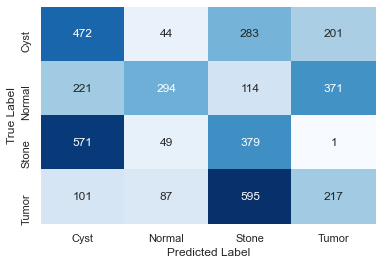

In [102]:
y_pred = model2.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

error: 0.5671828171828172
Test prediction accuracy: 0.433


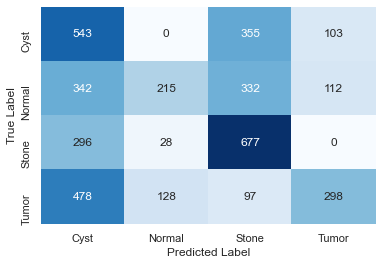

In [103]:
y_pred = model2.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 3: Decision Tree

In [106]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
startTime = time.time()
dt.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')
print('Val accuracy:', dt.score(X_val_flat, y_val))
print('Test accuracy:', dt.score(X_test_flat, y_test))


Training took 5.130970346927643 minutes
Val accuracy: 0.3065
Test accuracy: 0.44555444555444557


Output: /Users/karachristensen/MidsWork/207/CarriganNeginKaraFinalProject/iris-decisiontree.jpg


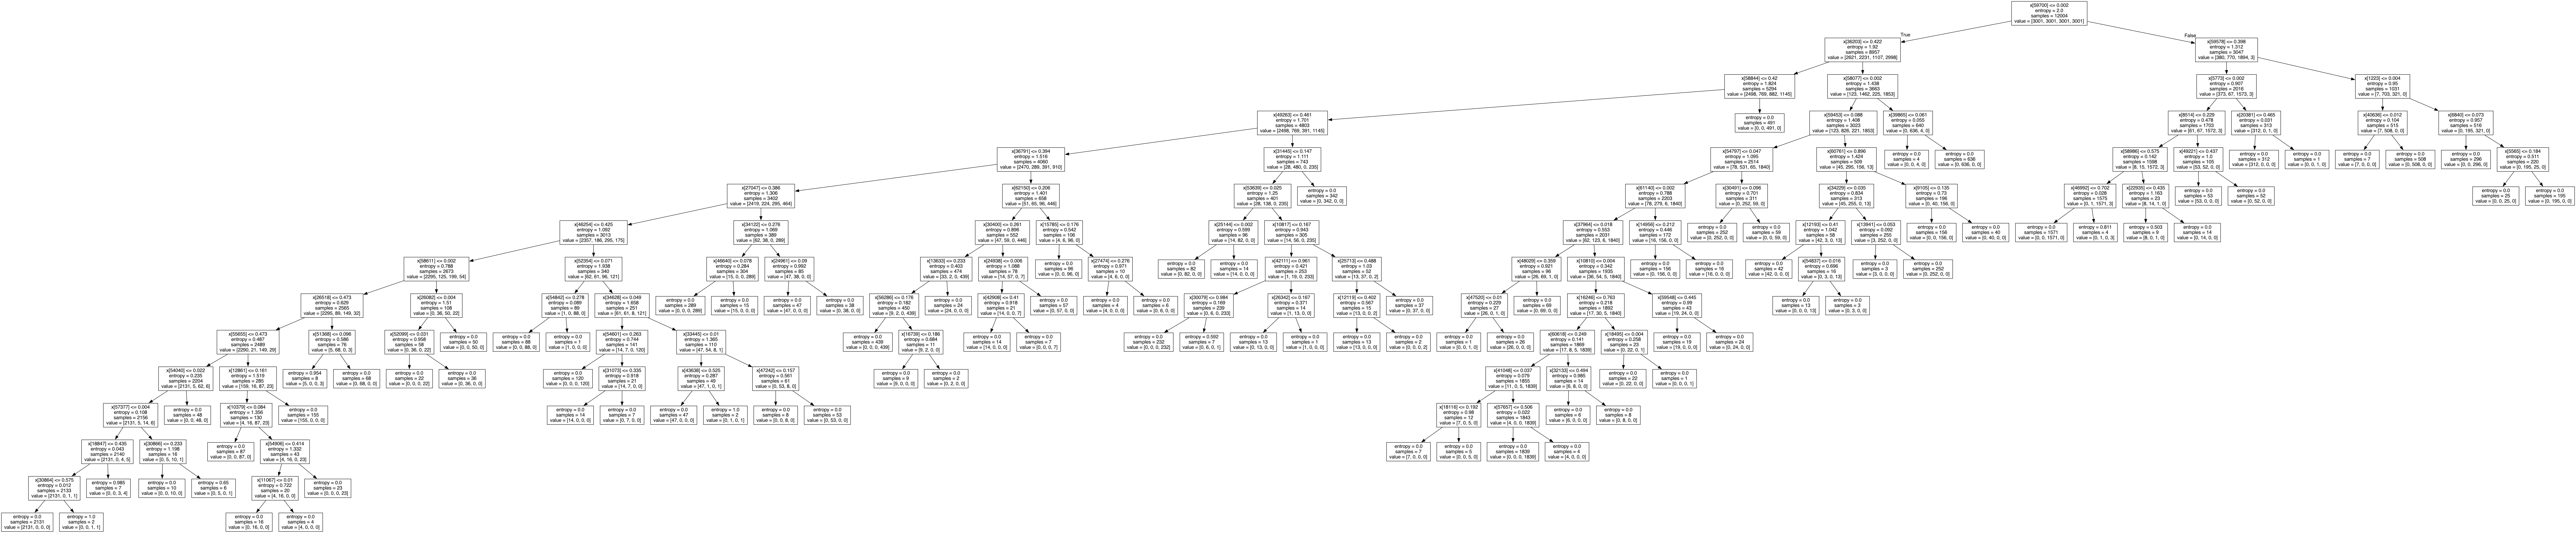

In [107]:
# Export and visualize the trained tree
import os

output_name = 'iris-decisiontree.jpg'
full_path = os.path.join(os.getcwd(), output_name)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]

graph.write_png(output_name)
print('Output:', full_path)
display(Image(filename=full_path))

## Neural Network Machine Learning Models

### Model 4 - Neural Network

In [108]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(data_augmentation)
    model.add(tf.keras.layers.Flatten())
    
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


In [114]:
# Build and compile the model
model4_sgd = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                         optimizer='SGD', learning_rate=0.001)
numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_sgd.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()




Epoch 1/15
188/188 [==============================] - 12s 61ms/step - loss: 1.3993 - accuracy: 0.2622 - recall_c1: 0.2347 - precision_c1: 0.2624 - recall_c2: 0.2990 - precision_c2: 0.2560 - recall_c3: 0.2522 - precision_c3: 0.2313 - recall_c4: 0.2619 - precision_c4: 0.2474 - val_loss: 1.3781 - val_accuracy: 0.3363 - val_recall_c1: 0.7344 - val_precision_c1: 0.3310 - val_recall_c2: 0.2807 - val_precision_c2: 0.3089 - val_recall_c3: 0.0346 - val_precision_c3: 0.1024 - val_recall_c4: 0.2971 - val_precision_c4: 0.5169
Epoch 2/15
188/188 [==============================] - 10s 56ms/step - loss: 1.3868 - accuracy: 0.2745 - recall_c1: 0.2993 - precision_c1: 0.2879 - recall_c2: 0.3031 - precision_c2: 0.2876 - recall_c3: 0.2680 - precision_c3: 0.2652 - recall_c4: 0.2296 - precision_c4: 0.2433 - val_loss: 1.3701 - val_accuracy: 0.3050 - val_recall_c1: 0.5249 - val_precision_c1: 0.3102 - val_recall_c2: 0.5462 - val_precision_c2: 0.3598 - val_recall_c3: 0.0219 - val_precision_c3: 0.0818 - val_recal

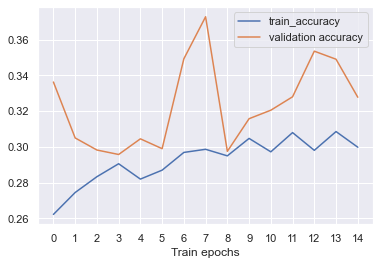

In [115]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [116]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.399321,0.262246,0.234682,0.262411,0.299010,0.256049,0.252210,0.231338,0.261892,0.247419,1.378101,0.33625,0.734434,0.330969,0.280660,0.308947,0.034637,0.102406,0.297107,0.516938
1,1.386836,0.274492,0.299315,0.287913,0.303112,0.287588,0.267967,0.265194,0.229642,0.243342,1.370137,0.30500,0.524860,0.310182,0.546162,0.359831,0.021913,0.081765,0.137743,0.259207
2,1.380385,0.283322,0.346099,0.317516,0.346765,0.286425,0.233953,0.261361,0.211942,0.252175,1.336254,0.29825,0.451066,0.344593,0.579466,0.324341,0.053889,0.172770,0.117908,0.186179
3,1.374264,0.290570,0.384414,0.318550,0.373462,0.287909,0.198847,0.234208,0.196912,0.254449,1.333767,0.29575,0.459089,0.330511,0.447628,0.355492,0.091474,0.144317,0.183152,0.255678
4,1.376430,0.281989,0.364164,0.302706,0.333287,0.291727,0.211812,0.255483,0.210735,0.243314,1.327847,0.30450,0.572338,0.329404,0.590980,0.333044,0.000000,0.000000,0.062293,0.155361
5,1.375806,0.286988,0.394230,0.309360,0.354896,0.287234,0.180218,0.229072,0.222662,0.278823,1.304490,0.29900,0.437867,0.376262,0.631642,0.306411,0.118759,0.168237,0.015415,0.117989
6,1.371518,0.296901,0.401157,0.325220,0.374564,0.302165,0.199579,0.233931,0.203658,0.286626,1.313851,0.34925,0.538026,0.328523,0.548938,0.394299,0.192631,0.372772,0.127598,0.269989
7,1.368222,0.298650,0.421429,0.336515,0.358785,0.304868,0.195287,0.284540,0.224090,0.278847,1.323241,0.37275,0.717580,0.317629,0.552725,0.436605,0.091216,0.362056,0.135027,0.549704
8,1.365640,0.294985,0.421793,0.320257,0.358842,0.301294,0.183656,0.277782,0.204202,0.264376,1.296399,0.29750,0.491033,0.336829,0.641929,0.292860,0.004875,0.042328,0.062111,0.223312
9,1.362061,0.304732,0.447257,0.333187,0.375347,0.295619,0.170260,0.285748,0.225785,0.271286,1.291739,0.31575,0.538492,0.356846,0.688654,0.313831,0.032796,0.114853,0.015415,0.143122


In [117]:
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 2.6470539848009746 minutes


125/125 [==============================] - 1s 7ms/step


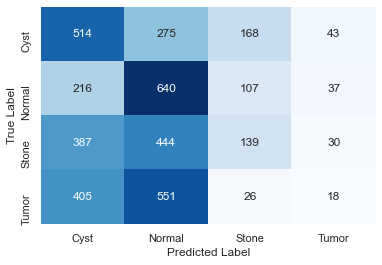

In [118]:
test_predictions = np.argmax(model4_sgd.predict(X_val), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [121]:
model4_rms = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                         optimizer='RMSprop', learning_rate=0.001)

numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_rms.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()

Epoch 1/15
188/188 [==============================] - 38s 196ms/step - loss: 13.3127 - accuracy: 0.2552 - recall_c1: 0.2602 - precision_c1: 0.0943 - recall_c2: 0.2594 - precision_c2: 0.0869 - recall_c3: 0.2466 - precision_c3: 0.0857 - recall_c4: 0.2485 - precision_c4: 0.0828 - val_loss: 4.6307 - val_accuracy: 0.2775 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_recall_c3: 0.9741 - val_precision_c3: 0.2904 - val_recall_c4: 0.1359 - val_precision_c4: 0.2187
Epoch 2/15
188/188 [==============================] - 37s 195ms/step - loss: 7.8390 - accuracy: 0.2617 - recall_c1: 0.2520 - precision_c1: 0.1148 - recall_c2: 0.2612 - precision_c2: 0.1074 - recall_c3: 0.2621 - precision_c3: 0.0873 - recall_c4: 0.2515 - precision_c4: 0.0988 - val_loss: 3.8445 - val_accuracy: 0.2750 - val_recall_c1: 0.2963 - val_precision_c1: 0.2502 - val_recall_c2: 0.7171 - val_precision_c2: 0.2855 - val_recall_c3: 0.0949 - val_precision_c3:

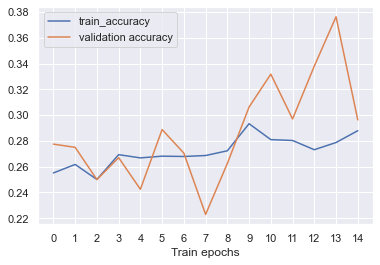

In [122]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [123]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,13.312694,0.255165,0.260174,0.094342,0.259352,0.086925,0.246624,0.085744,0.248453,0.082848,4.630657,0.27750,0.000000,0.000000,0.000000,0.000000,0.974118,0.290411,0.135928,0.218691
1,7.839042,0.261746,0.252016,0.114837,0.261154,0.107363,0.262067,0.087261,0.251454,0.098805,3.844459,0.27500,0.296301,0.250195,0.717080,0.285514,0.094944,0.305089,0.000000,0.000000
2,6.203951,0.250083,0.272298,0.120526,0.266094,0.106579,0.249822,0.096147,0.250848,0.101065,3.671343,0.25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250661
3,4.625852,0.269327,0.261532,0.130231,0.275169,0.129092,0.261000,0.100965,0.266822,0.131718,5.062169,0.26700,0.250790,0.361107,0.000000,0.000000,0.823858,0.248087,0.000000,0.000000
4,4.244418,0.266828,0.280076,0.128020,0.254805,0.126267,0.266254,0.127357,0.263127,0.113935,2.957165,0.24250,0.000000,0.000000,0.000000,0.000000,0.082068,0.226167,0.888019,0.246356
5,3.583001,0.268161,0.282026,0.157989,0.261079,0.137658,0.277017,0.151141,0.261846,0.150622,2.872969,0.28875,0.096148,0.606349,0.464439,0.321562,0.000000,0.000000,0.590932,0.243936
6,3.501084,0.267911,0.284634,0.135960,0.258124,0.125644,0.260625,0.110264,0.257861,0.140434,2.101053,0.27050,0.420478,0.298688,0.243415,0.354047,0.422073,0.219909,0.000000,0.000000
7,3.424289,0.268660,0.296501,0.132017,0.267073,0.147807,0.275311,0.128551,0.252703,0.150707,1.800311,0.22300,0.267937,0.519935,0.126834,0.276229,0.206240,0.138789,0.296936,0.185771
8,3.306532,0.272326,0.301574,0.158461,0.284243,0.151610,0.253820,0.126450,0.263013,0.132402,2.065972,0.26250,0.017514,0.183862,0.000000,0.000000,0.250378,0.216237,0.778840,0.279403
9,2.880765,0.293319,0.317839,0.216431,0.273957,0.189428,0.284937,0.164547,0.281171,0.161639,1.927914,0.30625,0.490787,0.333356,0.649298,0.303983,0.091251,0.253479,0.000000,0.000000


In [124]:
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 9.326523900032043 minutes


125/125 [==============================] - 2s 15ms/step


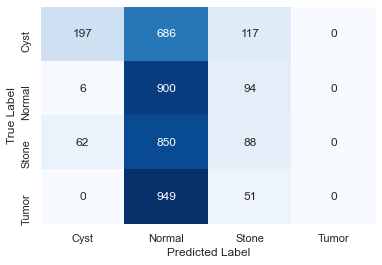

In [125]:
test_predictions = np.argmax(model4_rms.predict(X_val), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [128]:
model4_adam = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                          optimizer='Adam', learning_rate=0.0001)

numEpochs = 15

# Train the model for 5 epochs
startTime = time.time()
history = model4_adam.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()




Epoch 1/15
188/188 [==============================] - 24s 119ms/step - loss: 1.4514 - accuracy: 0.2572 - recall_c1: 0.1788 - precision_c1: 0.1428 - recall_c2: 0.2443 - precision_c2: 0.1527 - recall_c3: 0.2808 - precision_c3: 0.1715 - recall_c4: 0.3261 - precision_c4: 0.1716 - val_loss: 1.3409 - val_accuracy: 0.3395 - val_recall_c1: 0.5474 - val_precision_c1: 0.3693 - val_recall_c2: 0.0608 - val_precision_c2: 0.1227 - val_recall_c3: 0.2635 - val_precision_c3: 0.5349 - val_recall_c4: 0.4801 - val_precision_c4: 0.3189
Epoch 2/15
188/188 [==============================] - 20s 107ms/step - loss: 1.3905 - accuracy: 0.2680 - recall_c1: 0.2917 - precision_c1: 0.2211 - recall_c2: 0.2052 - precision_c2: 0.1559 - recall_c3: 0.2976 - precision_c3: 0.2105 - recall_c4: 0.3049 - precision_c4: 0.2258 - val_loss: 1.3644 - val_accuracy: 0.2808 - val_recall_c1: 0.2914 - val_precision_c1: 0.4463 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_recall_c3: 0.0377 - val_precision_c3: 0.1322 -

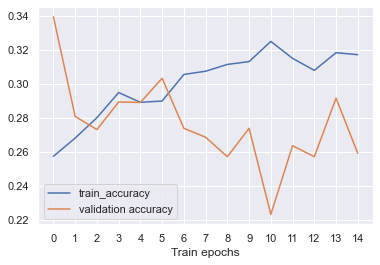

In [129]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [130]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.451434,0.257248,0.178839,0.142793,0.244265,0.152671,0.280763,0.171509,0.326134,0.171633,1.340900,0.33950,0.547396,0.369328,0.060754,0.122735,0.263506,0.534885,0.480050,0.318918
1,1.390481,0.267994,0.291724,0.221089,0.205213,0.155880,0.297590,0.210532,0.304927,0.225797,1.364437,0.28075,0.291414,0.446338,0.000000,0.000000,0.037690,0.132213,0.796172,0.270353
2,1.381850,0.279990,0.262622,0.277810,0.201760,0.227073,0.324148,0.240230,0.324589,0.222785,1.388906,0.27300,0.195219,0.330949,0.000000,0.000000,0.049973,0.189462,0.852632,0.270607
3,1.374929,0.294818,0.350717,0.258876,0.252433,0.248664,0.256882,0.228731,0.297848,0.248994,1.362539,0.28925,0.370103,0.273466,0.000000,0.000000,0.229717,0.271576,0.565951,0.314851
4,1.375622,0.289070,0.328637,0.270278,0.266624,0.281194,0.296838,0.243068,0.260099,0.205549,1.332198,0.28900,0.399050,0.289344,0.126525,0.179971,0.148001,0.382057,0.482159,0.314800
5,1.376210,0.289820,0.387778,0.292640,0.323121,0.286275,0.313774,0.254883,0.139748,0.148626,1.346920,0.30325,0.413952,0.336150,0.064763,0.212440,0.270144,0.323987,0.460613,0.282818
6,1.366204,0.305481,0.414849,0.292369,0.352022,0.312150,0.295566,0.265964,0.146724,0.178174,1.336192,0.27375,0.374418,0.290639,0.045473,0.151039,0.218537,0.310824,0.464852,0.269293
7,1.363327,0.307398,0.434230,0.314750,0.364186,0.309700,0.302570,0.252526,0.126139,0.163910,1.359729,0.26850,0.542711,0.286046,0.140473,0.320876,0.013303,0.037667,0.377007,0.282424
8,1.355719,0.311396,0.439450,0.307834,0.385424,0.286661,0.286951,0.294735,0.125349,0.217029,1.321113,0.25700,0.433359,0.301690,0.436212,0.261189,0.170126,0.312671,0.000000,0.000000
9,1.358160,0.313062,0.426714,0.307089,0.367776,0.289591,0.287020,0.281746,0.142293,0.240668,1.321067,0.27375,0.412658,0.321603,0.457840,0.265418,0.220427,0.350370,0.014499,0.040615


In [131]:
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Training took 5.201327252388 minutes


125/125 [==============================] - 1s 10ms/step


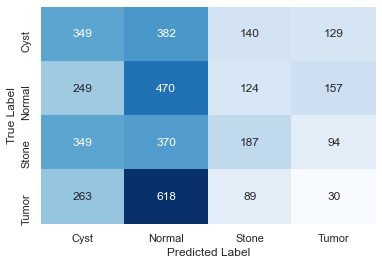

In [132]:
test_predictions = np.argmax(model4_adam.predict(X_val), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Models 5-6 - CNN

In [133]:
def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):

    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [134]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [135]:
#new_shape = (32, 32, 3)
X_train_reshaped = np.reshape(X_train_flat, (-1, 256, 256, 1))
X_val_reshaped = np.reshape(X_val_flat, (-1, 256, 256, 1))
X_test_reshaped = np.reshape(X_test_flat, (-1, 256, 256, 1))
# Normalize pixel values to range [0, 1]
# X_train_reshaped = X_train_reshaped / 255.0
# X_val_reshaped = X_val_reshaped / 255.0
# X_test_reshaped = X_test_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])
X_test_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_test_reshaped])


In [136]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)


In [137]:
# Train the CNN model for 5 epochs
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.001)
numEpochs = 25
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/25
188/188 [==============================] - 10s 45ms/step - loss: 1.3828 - accuracy: 0.2682 - recall_c1: 0.0010 - precision_c1: 0.0160 - recall_c2: 0.9354 - precision_c2: 0.2724 - recall_c3: 0.0000e+00 - precision_c3: 0.0000e+00 - recall_c4: 0.1357 - precision_c4: 0.2461 - val_loss: 1.3797 - val_accuracy: 0.3000 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.8750 - val_precision_c2: 0.3780 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.3269 - val_precision_c4: 0.1917
Epoch 2/25
188/188 [==============================] - 9s 48ms/step - loss: 1.3762 - accuracy: 0.2789 - recall_c1: 0.0020 - precision_c1: 0.0266 - recall_c2: 0.8821 - precision_c2: 0.2913 - recall_c3: 0.0000e+00 - precision_c3: 0.0000e+00 - recall_c4: 0.2308 - precision_c4: 0.2437 - val_loss: 1.3743 - val_accuracy: 0.3077 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.9430 - val_precision_c2: 0.3799 - val_recall_c3: 0.0000

Epoch 17/25
188/188 [==============================] - 8s 44ms/step - loss: 1.2362 - accuracy: 0.4768 - recall_c1: 0.7935 - precision_c1: 0.5739 - recall_c2: 0.8717 - precision_c2: 0.4183 - recall_c3: 0.1183 - precision_c3: 0.3773 - recall_c4: 0.1238 - precision_c4: 0.5714 - val_loss: 1.2252 - val_accuracy: 0.5535 - val_recall_c1: 0.8468 - val_precision_c1: 0.5221 - val_recall_c2: 0.8356 - val_precision_c2: 0.5793 - val_recall_c3: 0.4448 - val_precision_c3: 0.6070 - val_recall_c4: 0.0813 - val_precision_c4: 0.4239
Epoch 18/25
188/188 [==============================] - 8s 43ms/step - loss: 1.2204 - accuracy: 0.4841 - recall_c1: 0.8030 - precision_c1: 0.5664 - recall_c2: 0.8689 - precision_c2: 0.4311 - recall_c3: 0.1374 - precision_c3: 0.3814 - recall_c4: 0.1293 - precision_c4: 0.5993 - val_loss: 1.2092 - val_accuracy: 0.5715 - val_recall_c1: 0.8623 - val_precision_c1: 0.5180 - val_recall_c2: 0.7994 - val_precision_c2: 0.6606 - val_recall_c3: 0.4971 - val_precision_c3: 0.5817 - val_recal

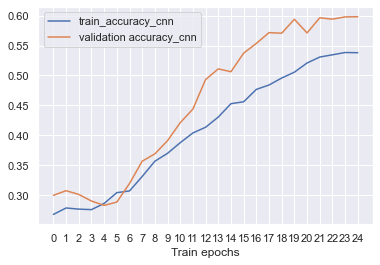

In [138]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [140]:
history = pd.DataFrame(history_cnn.history)
display(history)

,loss,accuracy,recall_c1,precision_c1,recall_c2,precision_c2,recall_c3,precision_c3,recall_c4,precision_c4,val_loss,val_accuracy,val_recall_c1,val_precision_c1,val_recall_c2,val_precision_c2,val_recall_c3,val_precision_c3,val_recall_c4,val_precision_c4
0,1.382777,0.268161,0.001037,0.015957,0.935449,0.272385,0.000000,0.000000,0.135698,0.246139,1.379699,0.30000,0.000000,0.000000,0.875001,0.377955,0.000000,0.000000,0.326941,0.191704
1,1.376202,0.278907,0.002015,0.026596,0.882075,0.291284,0.000000,0.000000,0.230781,0.243696,1.374344,0.30775,0.000000,0.000000,0.942953,0.379949,0.000000,0.000000,0.291682,0.190202
2,1.371377,0.276991,0.003328,0.053191,0.959463,0.282700,0.000000,0.000000,0.145086,0.245379,1.369599,0.30150,0.000000,0.000000,0.964986,0.364439,0.000000,0.000000,0.244908,0.179650
3,1.365968,0.276158,0.018181,0.192908,0.977476,0.282907,0.000946,0.013298,0.108853,0.212192,1.364635,0.29050,0.000000,0.000000,0.979825,0.346909,0.000000,0.000000,0.185519,0.160063
4,1.361178,0.286488,0.062243,0.429876,0.986837,0.286098,0.013559,0.141401,0.086482,0.240354,1.359460,0.28325,0.010652,0.121693,0.996992,0.322399,0.000000,0.000000,0.128255,0.150012
5,1.355491,0.304482,0.140334,0.593993,0.983285,0.288761,0.027290,0.217021,0.066573,0.256944,1.353668,0.28875,0.054630,0.293122,0.998866,0.313450,0.002050,0.031746,0.100303,0.165182
6,1.349307,0.307314,0.165019,0.564247,0.985424,0.287004,0.034170,0.240248,0.045051,0.285664,1.347499,0.31975,0.169996,0.529308,1.000000,0.319859,0.011061,0.077249,0.097009,0.229600
7,1.342682,0.331473,0.277487,0.600572,0.970333,0.297101,0.030649,0.181738,0.044203,0.329851,1.340316,0.35700,0.299413,0.667501,0.997984,0.337340,0.038394,0.124559,0.090026,0.273633
8,1.334813,0.356964,0.375244,0.599521,0.962075,0.316450,0.034129,0.188602,0.054770,0.330404,1.332063,0.36925,0.381003,0.716519,1.000000,0.334340,0.041797,0.158787,0.051054,0.228061
9,1.326102,0.370127,0.441763,0.581982,0.957508,0.324882,0.024428,0.119612,0.058129,0.377660,1.323039,0.39125,0.424509,0.714595,0.996446,0.348903,0.091349,0.285501,0.048924,0.225737


125/125 [==============================] - 1s 4ms/step


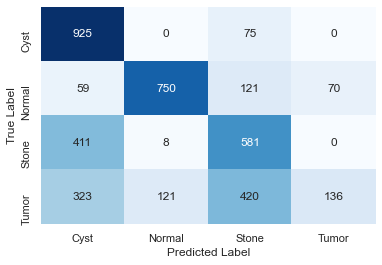

In [141]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.0001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
history = pd.DataFrame(history_cnn.history)
display(history)

In [ ]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
#building a new CNN model increasing the number of filters

def build_new_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Adding drop out layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [ ]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
numEpochs = 20
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Test CNN Model and Create ROC Curve

In [ ]:
predictions = cnn_model.predict(X_test_rgb)
class_predictions = np.argmax(predictions, axis=-1)
print(class_predictions)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class CNN')
plt.legend()
plt.show()

## Ensemble Machine Learning Models

### Model 7 - Random Forest

In [ ]:
if len(X_train.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_train.shape[0]
    X_train = X_train.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact


In [ ]:
if len(X_test.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_test.shape[0]
    X_test = X_test.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=42)

# Training the Random Forest classifier
startTime = time.time()
rf_classifier.fit(X_train, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

# Making predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = rf_classifier.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy}")

### Model 8 - XGBoost

In [ ]:
model8 = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)
startTime = time.time()
model8.fit(X_train_flat, y_train)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
y_pred = model8.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
y_pred = model8.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 9 - Transfer Learning

In [ ]:
# Should have shape (12004, 256, 256, 1) at start of cell

print(X_train.shape, X_val.shape)
X_train_3_channel = X_train.repeat(3, axis=-1)
X_val_3_channel = X_val.repeat(3, axis = -1)

print(X_train_3_channel.shape, X_val_3_channel.shape)

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
               keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model9 = keras.Model(inputs, outputs)

model9.summary()

In [ ]:
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model9.fit(X_train_3_channel, 
                     y_train, 
                     epochs=10, 
                     batch_size=128, 
                     validation_data = (X_val_3_channel, y_val))
endTime = time.time()

print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(model9.predict(X_val_3_channel), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 10 - ViT (Transfer Learning Vision Transformer)

In [ ]:
# Create base model
image_size = 256
basemodel10 = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False
    ,pretrained_top=False
#     ,classes=4
)

# Freeze base model
basemodel10.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = basemodel10(x, training = False)
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model10 = keras.Model(inputs, outputs)


model10.summary()

In [ ]:
model10.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model10.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, 
            validation_data = (X_val_3_channel, y_val), verbose = 1)
endTime = time.time()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(model10.predict(X_val_3_channel), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()